<a href="https://colab.research.google.com/github/yunaficus/DRL/blob/main/HW3_MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Epsilon-Greedy


$$
a_t =
\begin{cases}
\text{random action} & \text{with probability } \varepsilon \\
\arg\max_a Q_t(a) & \text{with probability } 1 - \varepsilon
\end{cases}
$$

$$
Q_{t+1}(a_t) = Q_t(a_t) + \alpha_t \left( R_t - Q_t(a_t) \right)
$$

參數說明：

$$
\begin{aligned}
\varepsilon & : \text{探索率（exploration rate）} \\
Q_t(a) & : \text{第 } t \text{ 步對動作 } a \text{ 的預估獎勵} \\
\alpha_t & : \text{學習率，通常設定為 } \frac{1}{N_t(a)} \text{（第 } t \text{ 步前動作 } a \text{ 被選擇的次數）} \\
R_t & : \text{第 } t \text{ 步獲得的實際獎勵}
\end{aligned}
$$


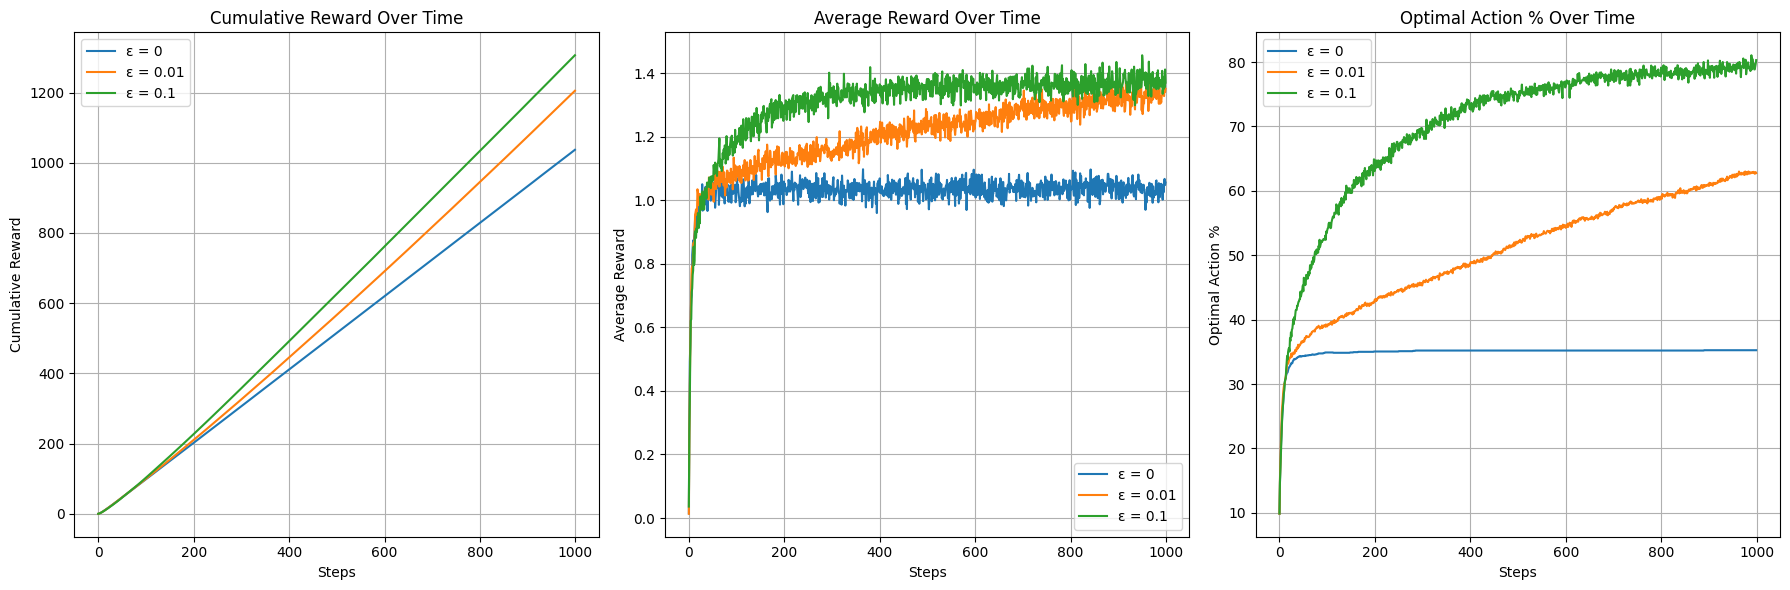

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Epsilon-Greedy Bandit ----
class EpsilonGreedyBandit:
    def __init__(self, k=10, epsilon=0.1, steps=1000, runs=2000):
        self.k = k
        self.epsilon = epsilon
        self.steps = steps
        self.runs = runs

    def simulate(self, q_true):
        # 初始化
        q_est = np.zeros((self.runs, self.k))
        action_count = np.zeros((self.runs, self.k))
        rewards = np.zeros((self.runs, self.steps))
        optimal_action_counts = np.zeros((self.runs, self.steps))

        optimal_actions = np.argmax(q_true, axis=1)

        for t in range(self.steps):
            # Epsilon-Greedy 選擇
            rand_vals = np.random.rand(self.runs)
            explore = rand_vals < self.epsilon
            exploit = ~explore

            actions = np.zeros(self.runs, dtype=int)
            actions[explore] = np.random.randint(0, self.k, np.sum(explore))
            actions[exploit] = np.argmax(q_est, axis=1)[exploit]

            # 記錄選到最佳臂的比例
            optimal_action_counts[:, t] = (actions == optimal_actions)

            # 拿到 reward
            reward = np.random.normal(q_true[np.arange(self.runs), actions], 1)
            rewards[:, t] = reward

            # 更新 Q
            action_count[np.arange(self.runs), actions] += 1
            alpha = 1 / action_count[np.arange(self.runs), actions]
            q_est[np.arange(self.runs), actions] += alpha * (reward - q_est[np.arange(self.runs), actions])

        return rewards, optimal_action_counts

# ---- 繪圖 ----
def plot_bandits():
    epsilons = [0, 0.01, 0.1]
    steps = 1000
    runs = 2000
    k = 10

    # 只生成一組固定的 q_true (確保公平比較)
    q_true = np.random.normal(0, 1, (runs, k))

    plt.figure(figsize=(18, 6))

    # ----- 左圖: Cumulative Reward -----
    plt.subplot(1, 3, 1)
    for eps in epsilons:
        bandit = EpsilonGreedyBandit(k=k, epsilon=eps, steps=steps, runs=runs)
        rewards, _ = bandit.simulate(q_true)
        cumulative_reward = rewards.cumsum(axis=1).mean(axis=0)
        plt.plot(cumulative_reward, label=f'ε = {eps}')
    plt.title('Cumulative Reward Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)


    # ----- 中圖: Average Reward Over Time -----

    plt.subplot(1, 3, 2)
    for eps in epsilons:
        bandit = EpsilonGreedyBandit(k=k, epsilon=eps, steps=steps, runs=runs)
        rewards, _ = bandit.simulate(q_true)
        avg_rewards = rewards.mean(axis=0)
        plt.plot(avg_rewards, label=f'ε = {eps}')
    plt.title('Average Reward Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)

    # ----- 右圖: Optimal Action % -----
    plt.subplot(1, 3, 3)
    for eps in epsilons:
        bandit = EpsilonGreedyBandit(k=k, epsilon=eps, steps=steps, runs=runs)
        _, optimal_action_counts = bandit.simulate(q_true)
        optimal_action_rate = optimal_action_counts.mean(axis=0) * 100
        plt.plot(optimal_action_rate, label=f'ε = {eps}')
    plt.title('Optimal Action % Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Optimal Action %')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ---- 執行 ----
plot_bandits()


## UCB

$$
a_t = \arg\max_a \left[ Q_t(a) + c \cdot \sqrt{ \frac{\ln t}{N_t(a)} } \right]
$$

$$
Q_{t+1}(a_t) = Q_t(a_t) + \alpha_t \left( R_t - Q_t(a_t) \right)
$$

參數說明：

$$
\begin{aligned}
Q_t(a) & : \text{對動作 } a \text{ 的預估獎勵} \\
c & : \text{控制探索程度的參數（confidence level）} \\
t & : \text{目前時間步數} \\
N_t(a) & : \text{動作 } a \text{ 在前 } t \text{ 步中被選擇的次數} \\
\alpha_t & : \text{學習率} \\
R_t & : \text{第 } t \text{ 步的實際獎勵}
\end{aligned}
$$


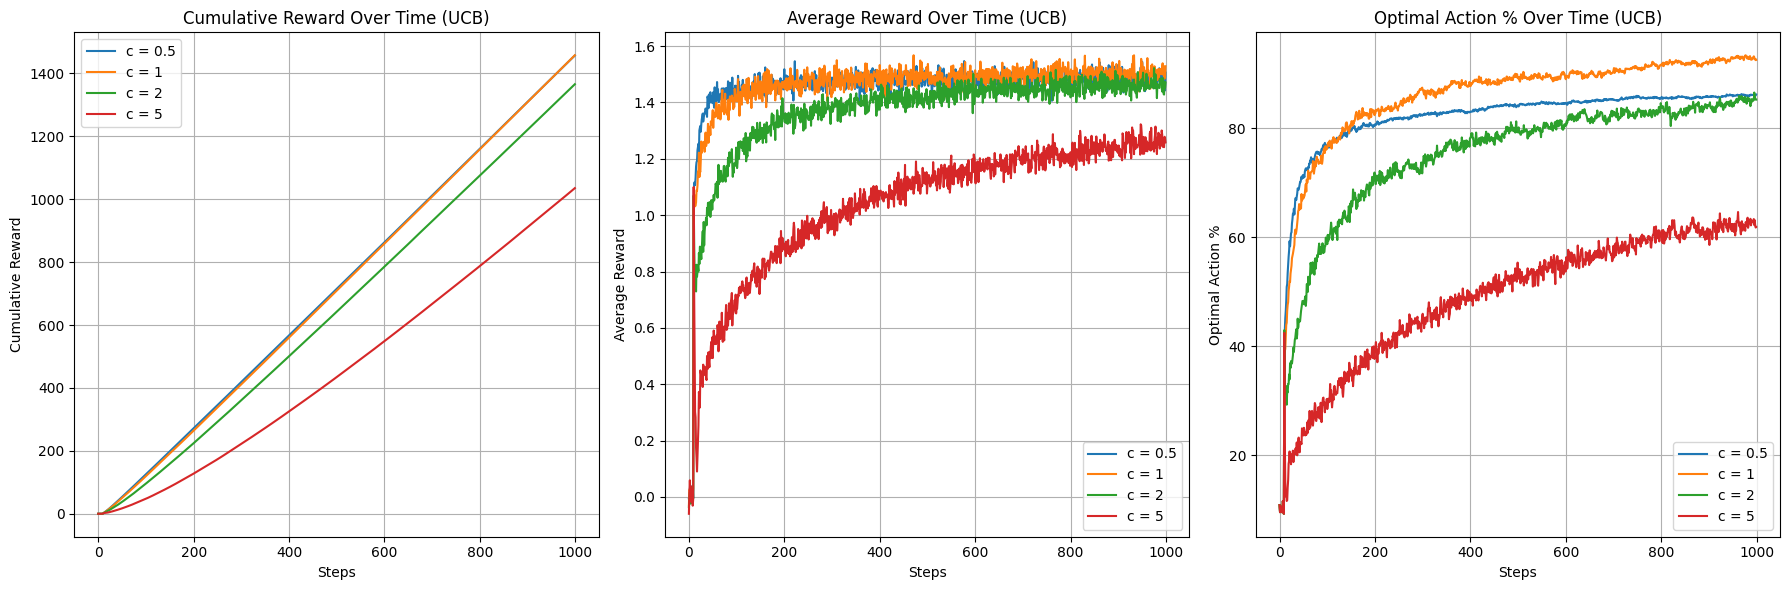

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- UCB Bandit ----
class UCBBandit:
    def __init__(self, k=10, c=2, steps=1000, runs=2000):
        self.k = k
        self.c = c
        self.steps = steps
        self.runs = runs

    def simulate(self, q_true):
        q_est = np.zeros((self.runs, self.k))
        action_count = np.zeros((self.runs, self.k))
        rewards = np.zeros((self.runs, self.steps))
        optimal_action_counts = np.zeros((self.runs, self.steps))

        optimal_actions = np.argmax(q_true, axis=1)

        for t in range(self.steps):
            # UCB 選擇
            confidence = self.c * np.sqrt(np.log(t + 1 + 1) / (action_count + 1e-5))  # 加1避免log(0)，除1e-5避免除0
            ucb_values = q_est + confidence
            actions = np.argmax(ucb_values, axis=1)

            # 記錄最佳臂
            optimal_action_counts[:, t] = (actions == optimal_actions)

            # 拿到 reward
            reward = np.random.normal(q_true[np.arange(self.runs), actions], 1)
            rewards[:, t] = reward

            # 更新 Q
            action_count[np.arange(self.runs), actions] += 1
            alpha = 1 / action_count[np.arange(self.runs), actions]
            q_est[np.arange(self.runs), actions] += alpha * (reward - q_est[np.arange(self.runs), actions])

        return rewards, optimal_action_counts

# ---- 繪圖 ----
def plot_ucb_bandits():
    cs = [0.5, 1, 2, 5]
    steps = 1000
    runs = 2000
    k = 10

    # 只生成一組固定的 q_true (確保公平比較)
    q_true = np.random.normal(0, 1, (runs, k))

    plt.figure(figsize=(18, 6))

    # ----- 左圖: Cumulative Reward -----
    plt.subplot(1, 3, 1)
    for c in cs:
        bandit = UCBBandit(k=k, c=c, steps=steps, runs=runs)
        rewards, _ = bandit.simulate(q_true)
        cumulative_reward = rewards.cumsum(axis=1).mean(axis=0)
        plt.plot(cumulative_reward, label=f'c = {c}')
    plt.title('Cumulative Reward Over Time (UCB)')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)

    # ----- 中圖: Average Reward Over Time -----
    plt.subplot(1, 3, 2)
    for c in cs:
        bandit = UCBBandit(k=k, c=c, steps=steps, runs=runs)
        rewards, _ = bandit.simulate(q_true)
        avg_rewards = rewards.mean(axis=0)
        plt.plot(avg_rewards, label=f'c = {c}')
    plt.title('Average Reward Over Time (UCB)')
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)

    # ----- 右圖: Optimal Action % -----
    plt.subplot(1, 3, 3)
    for c in cs:
        bandit = UCBBandit(k=k, c=c, steps=steps, runs=runs)
        _, optimal_action_counts = bandit.simulate(q_true)
        optimal_action_rate = optimal_action_counts.mean(axis=0) * 100
        plt.plot(optimal_action_rate, label=f'c = {c}')
    plt.title('Optimal Action % Over Time (UCB)')
    plt.xlabel('Steps')
    plt.ylabel('Optimal Action %')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ---- 執行 ----
plot_ucb_bandits()


## softmax

$$
P(a) = \frac{\exp\left(Q_t(a)/\tau\right)}{\sum_b \exp\left(Q_t(b)/\tau\right)}
$$

$$
Q_{t+1}(a_t) = Q_t(a_t) + \alpha_t (R_t - Q_t(a_t))
$$

參數說明：

$$
\begin{aligned}
P(a) & : \text{選擇動作 } a \text{ 的機率} \\
Q_t(a) & : \text{動作 } a \text{ 的預估獎勵} \\
\tau & : \text{溫度參數（temperature），決定探索程度} \\
\alpha_t & : \text{學習率} \\
R_t & : \text{實際獎勵}
\end{aligned}
$$


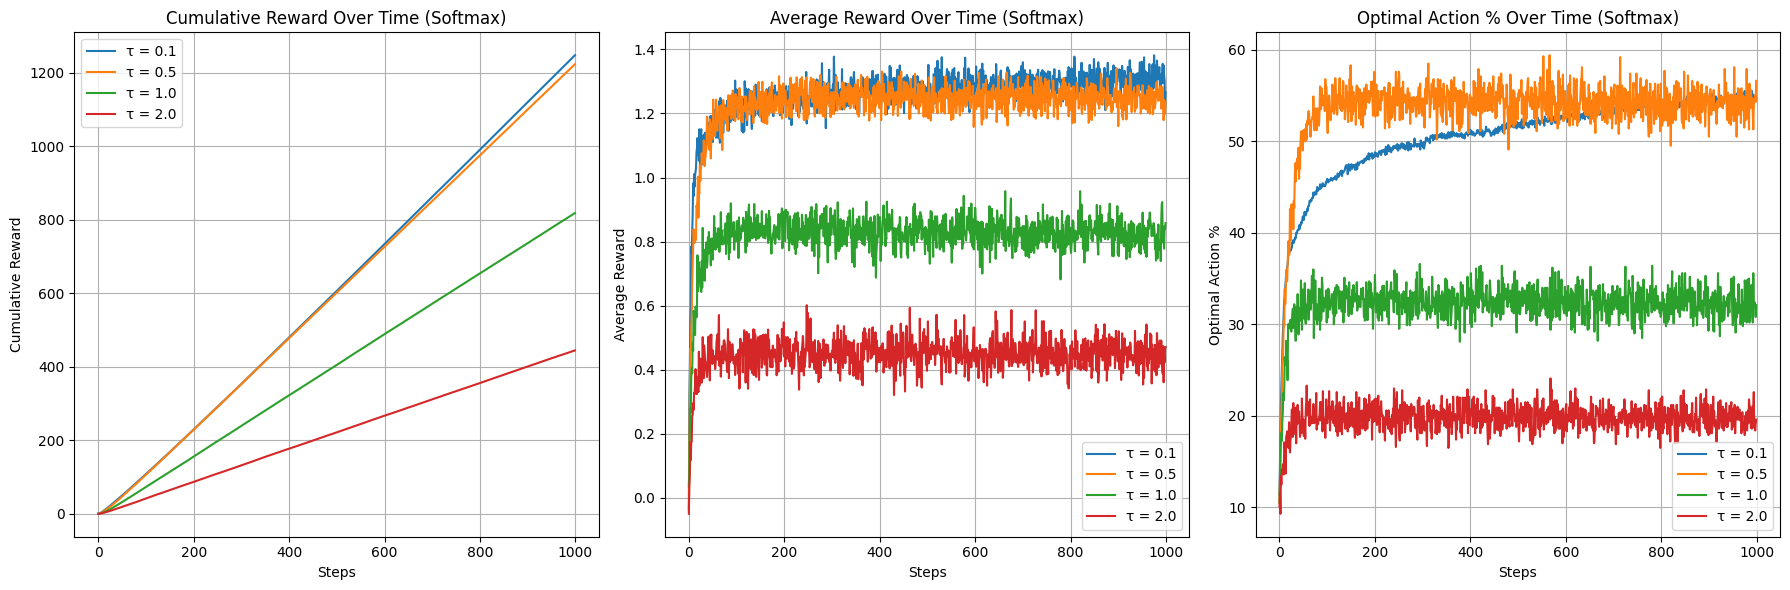

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Softmax Bandit ----
class SoftmaxBandit:
    def __init__(self, k=10, tau=0.5, steps=1000, runs=2000):
        self.k = k
        self.tau = tau
        self.steps = steps
        self.runs = runs

    def simulate(self, q_true):
        q_est = np.zeros((self.runs, self.k))
        action_count = np.zeros((self.runs, self.k))
        rewards = np.zeros((self.runs, self.steps))
        optimal_action_counts = np.zeros((self.runs, self.steps))

        optimal_actions = np.argmax(q_true, axis=1)

        for t in range(self.steps):
            # Softmax 選擇 action
            exp_q = np.exp(q_est / self.tau)
            probs = exp_q / np.sum(exp_q, axis=1, keepdims=True)
            actions = np.array([
                np.random.choice(self.k, p=probs[i])
                for i in range(self.runs)
            ])

            # 記錄是否選到最佳動作
            optimal_action_counts[:, t] = (actions == optimal_actions)

            # 獲得 reward
            reward = np.random.normal(q_true[np.arange(self.runs), actions], 1)
            rewards[:, t] = reward

            # 更新 Q 值
            action_count[np.arange(self.runs), actions] += 1
            alpha = 1 / action_count[np.arange(self.runs), actions]
            q_est[np.arange(self.runs), actions] += alpha * (reward - q_est[np.arange(self.runs), actions])

        return rewards, optimal_action_counts

# ---- 繪圖 ----
def plot_softmax_bandits():
    taus = [0.1, 0.5, 1.0, 2.0]  # 溫度參數
    steps = 1000
    runs = 1000
    k = 10

    # 固定一組 q_true（確保公平比較）
    q_true = np.random.normal(0, 1, (runs, k))

    plt.figure(figsize=(18, 6))

    # ----- 左圖: Cumulative Reward -----
    plt.subplot(1, 3, 1)
    for tau in taus:
        bandit = SoftmaxBandit(k=k, tau=tau, steps=steps, runs=runs)
        rewards, _ = bandit.simulate(q_true)
        cumulative_reward = rewards.cumsum(axis=1).mean(axis=0)
        plt.plot(cumulative_reward, label=f'τ = {tau}')
    plt.title('Cumulative Reward Over Time (Softmax)')
    plt.xlabel('Steps')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.grid(True)

    # ----- 中圖: Average Reward Over Time -----
    plt.subplot(1, 3, 2)
    for tau in taus:
        bandit = SoftmaxBandit(k=k, tau=tau, steps=steps, runs=runs)
        rewards, _ = bandit.simulate(q_true)
        avg_rewards = rewards.mean(axis=0)
        plt.plot(avg_rewards, label=f'τ = {tau}')
    plt.title('Average Reward Over Time (Softmax)')
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.grid(True)

    # ----- 右圖: Optimal Action % -----
    plt.subplot(1, 3, 3)
    for tau in taus:
        bandit = SoftmaxBandit(k=k, tau=tau, steps=steps, runs=runs)
        _, optimal_action_counts = bandit.simulate(q_true)
        optimal_action_rate = optimal_action_counts.mean(axis=0) * 100
        plt.plot(optimal_action_rate, label=f'τ = {tau}')
    plt.title('Optimal Action % Over Time (Softmax)')
    plt.xlabel('Steps')
    plt.ylabel('Optimal Action %')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ---- 執行 ----
plot_softmax_bandits()


## Thompson Sampling

$$
p_k \sim \text{Beta}(\alpha_k, \beta_k)
$$

$$
\hat{p}_k \sim \text{Beta}(\alpha_k, \beta_k)
$$

$$
k^* = \arg\max_k \hat{p}_k
$$

$$
\alpha_{k^*} \leftarrow \alpha_{k^*} + r_{k^*}
$$

$$
\beta_{k^*} \leftarrow \beta_{k^*} + (1 - r_{k^*})
$$


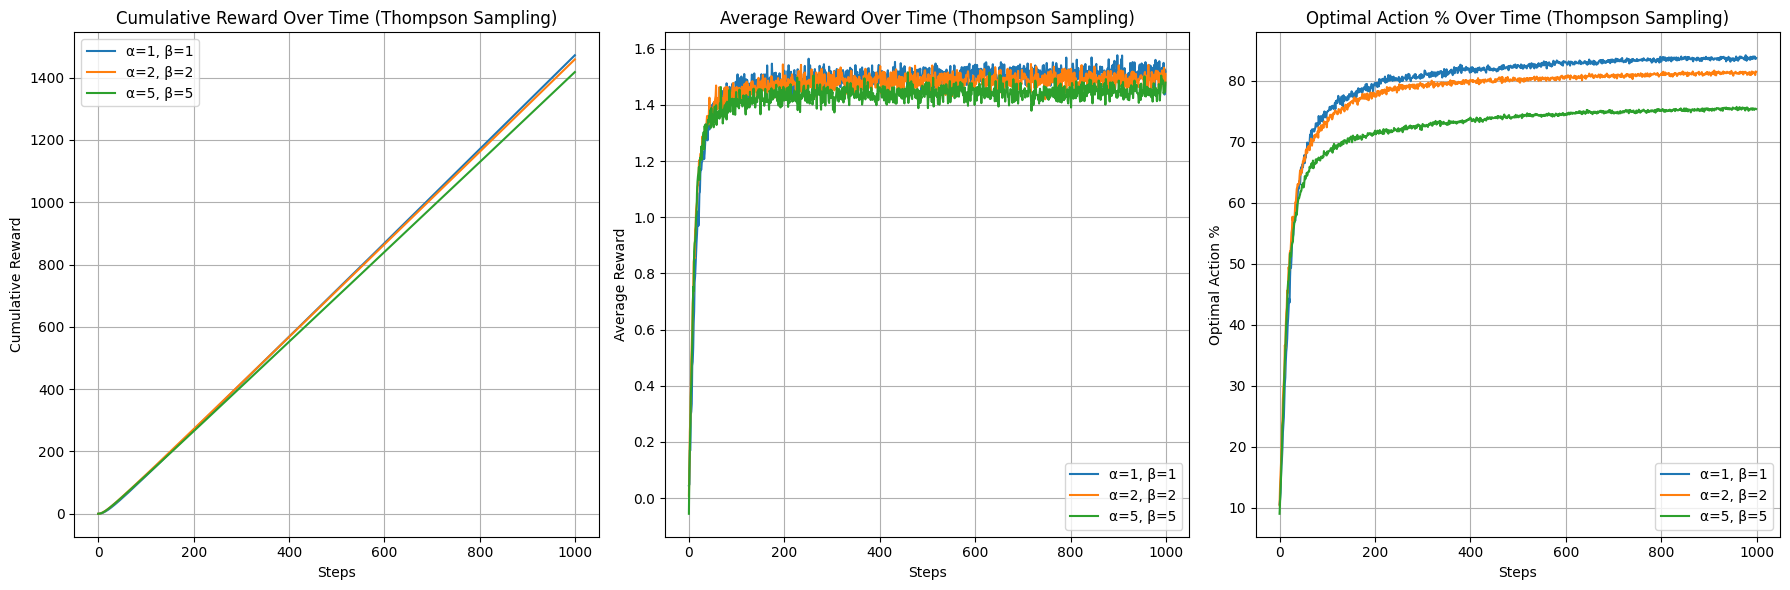

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Thompson Sampling Bandit ----
class ThompsonSamplingBandit:
    def __init__(self, k=10, steps=1000, runs=2000, alpha_init=1, beta_init=1):
        self.k = k
        self.steps = steps
        self.runs = runs
        self.alpha_init = alpha_init
        self.beta_init = beta_init

    def simulate(self, q_true):
        # 初始化 Alpha 和 Beta 分布的參數，並設置為浮點數類型
        alpha = np.full((self.runs, self.k), self.alpha_init, dtype=np.float64)  # 成功次數初始化為 alpha_init
        beta = np.full((self.runs, self.k), self.beta_init, dtype=np.float64)    # 失敗次數初始化為 beta_init

        rewards = np.zeros((self.runs, self.steps))
        optimal_action_counts = np.zeros((self.runs, self.steps))

        optimal_actions = np.argmax(q_true, axis=1)

        for t in range(self.steps):
            # 每次從 Beta 分布中抽取樣本
            sampled_values = np.random.beta(alpha, beta)

            # 選擇最大樣本值的 action
            actions = np.argmax(sampled_values, axis=1)

            # 記錄是否選擇了最佳臂
            optimal_action_counts[:, t] = (actions == optimal_actions)

            # 獲得實際獎勳
            reward = np.random.normal(q_true[np.arange(self.runs), actions], 1)
            rewards[:, t] = reward

            # 更新 Beta 分布
            # 獎勳為 1 (成功)，更新 alpha，否則更新 beta
            alpha[np.arange(self.runs), actions] += reward
            beta[np.arange(self.runs), actions] += (1 - reward)

            # 確保 alpha 和 beta 不小於 1
            alpha = np.maximum(alpha, 1)
            beta = np.maximum(beta, 1)

        return rewards, optimal_action_counts

# ---- 繪圖 ----
def plot_thompson_sampling_bandits():
    steps = 1000
    runs = 2000
    k = 10

    # 固定 q_true（確保公平比較）
    q_true = np.random.normal(0, 1, (runs, k))

    # 不同的 alpha 和 beta 初始值
    alpha_betas = [(1, 1), (2, 2), (5, 5)]  # 比較不同的 alpha 和 beta 初始值

    plt.figure(figsize=(18, 6))

    for alpha_init, beta_init in alpha_betas:
        # 初始化 Thompson Sampling Bandit 並執行模擬
        bandit = ThompsonSamplingBandit(k=k, steps=steps, runs=runs, alpha_init=alpha_init, beta_init=beta_init)
        rewards, optimal_action_counts = bandit.simulate(q_true)

        # ----- 左圖: Cumulative Reward -----
        plt.subplot(1, 3, 1)
        cumulative_reward = rewards.cumsum(axis=1).mean(axis=0)
        plt.plot(cumulative_reward, label=f'α={alpha_init}, β={beta_init}')
        plt.title('Cumulative Reward Over Time (Thompson Sampling)')
        plt.xlabel('Steps')
        plt.ylabel('Cumulative Reward')
        plt.legend()
        plt.grid(True)

        # ----- 中圖: Average Reward Over Time -----
        plt.subplot(1, 3, 2)
        avg_rewards = rewards.mean(axis=0)
        plt.plot(avg_rewards, label=f'α={alpha_init}, β={beta_init}')
        plt.title('Average Reward Over Time (Thompson Sampling)')
        plt.xlabel('Steps')
        plt.ylabel('Average Reward')
        plt.legend()
        plt.grid(True)

        # ----- 右圖: Optimal Action % -----
        plt.subplot(1, 3, 3)
        optimal_action_rate = optimal_action_counts.mean(axis=0) * 100
        plt.plot(optimal_action_rate, label=f'α={alpha_init}, β={beta_init}')
        plt.title('Optimal Action % Over Time (Thompson Sampling)')
        plt.xlabel('Steps')
        plt.ylabel('Optimal Action %')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# ---- 執行 ----
plot_thompson_sampling_bandits()


## Conclusion

# 🎯 演算法比較表

| 演算法               | 控制參數       | 平衡機制            | Cumulative Reward趨勢 | Average Reward趨勢 | Optimal Action %趨勢 | 收斂速度 | 參數敏感度 | 探索效率 |
|----------------------|----------------|---------------------|----------------------|--------------------|----------------------|----------|------------|-----------|
| Epsilon-Greedy       | ε              | 固定隨機探索比率    | ε增加→累積獎勵提高    | ε增加→平均獎勵提高  | ε增加→最佳行動比例提升| 中等     | 高         | 普通      |
| UCB                  | c              | 信賴區間＋利用       | c適中(1)時最佳        | c適中(1)時最佳      | c適中(1)時收斂最快     | 快速     | 中         | 高效      |
| Softmax              | τ              | 機率化平滑探索       | τ小(0.1-0.5)表現佳    | τ小(0.1-0.5)表現佳  | τ小(0.5)時收斂最佳     | 中等     | 高         | 依τ變化   |
| Thompson Sampling    | α, β (prior)   | 貝氏取樣             | 整體穩定高效          | 整體穩定高效        | 整體收斂快速穩定       | 非常快   | 低         | 高效自適應 |

---

# 🎯 空間與時間複雜度分析

| 演算法               | 時間複雜度 (每步) | 空間複雜度 |
|----------------------|------------------|-----------|
| Epsilon-Greedy       | \( O(k) \)        | \( O(k) \) |
| UCB                  | \( O(k) \)        | \( O(k) \) |
| Softmax              | \( O(k) \)        | \( O(k) \) |
| Thompson Sampling    | \( O(k) \)        | \( O(k) \) |

其中：
- \( k \)：臂的數量。
- 每步都需要考慮所有 arms，故時間與空間複雜度皆為 \( O(k) \)。

---

# 🎯 時間分析（Temporal Analysis）

- **Epsilon-Greedy**：
  - ε越大（如0.1）→ 初期探索越充分，累積獎勵和最佳行動比例提升更快。
  - ε=0時（完全利用）→ 初期表現穩定，但無法改善 suboptimal arms。
  - ε過大仍會造成穩定性下降。

- **UCB**：
  - c=1時效果最佳，收斂又快又穩。
  - c太小（0.5）→ 過早利用，稍降低長期表現。
  - c太大（5）→ 過度探索，收斂慢且平均獎勵偏低。

- **Softmax**：
  - τ小（0.1~0.5）效果最佳，可快速收斂。
  - τ大（1.0~2.0）→ 過度平滑，持續大量探索，Optimal Action%停滯不前。
  - 平均獎勵與累積獎勵明顯受 τ 控制，參數非常敏感。

- **Thompson Sampling**：
  - 不同 prior (α=1,2,5) 影響輕微，整體趨勢穩定。
  - α, β 越大 → 初期探索略增，但對最終收斂速度影響不大。
  - 非常快速且穩定收斂，空間與時間表現最佳。

---

# 🎯 空間分析（Spatial Analysis）

- **Epsilon-Greedy**：
  - 探索範圍固定比例，即使已知劣臂仍會持續嘗試，造成一定浪費。

- **UCB**：
  - 空間探索智慧，集中於高不確定性的臂，探索非常有效率。
  - 參數c控制探索強度，過大或過小都會降低空間利用效率。

- **Softmax**：
  - 探索與利用依 reward 差異平滑調整。
  - τ值影響探索範圍，大τ導致持續在差臂上分配資源。

- **Thompson Sampling**：
  - 空間探索完全自適應，基於後驗機率進行最合理取樣。
  - 初期寬廣探索，後期集中最佳臂，空間利用效率極高。

---

# 🎯 優勢與限制整理

| 演算法               | 優勢                  | 限制                    | 適用情境                    |
|----------------------|-----------------------|-------------------------|------------------------------|
| Epsilon-Greedy       | 簡單穩定，易實作       | 無效率探索，後期有浪費    | 環境穩定、成本低的任務        |
| UCB                  | 高效探索，快速收斂     | 需調c值，假設臂數固定     | 需要快速收斂、理論保證場景     |
| Softmax              | 可平滑探索控制         | 溫度設定敏感，容易錯過最優解| reward差異小、需柔性策略選擇   |
| Thompson Sampling    | 自適應探索與利用平衡   | 需處理後驗分布更新        | 動態環境、冷啟動、高不確定場景  |

---

# 🧠 綜合結論（建議收尾段）

- **短期快速收斂（如即時廣告推薦）→ UCB（c=1）最佳**
- **長期效益最大化、動態環境（如醫療試驗、投資）→ Thompson Sampling最佳**
- **初學者或簡單場景（如線上小實驗）→ Epsilon-Greedy**
- **若reward差異小、且希望避免過早收斂 → Softmax**

